In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload

In [2]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)
nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


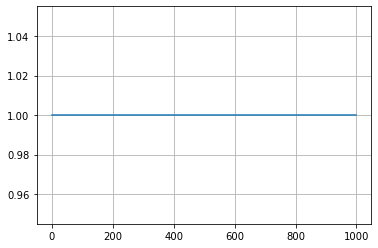

In [3]:
pix_size = 10 #arcmin
ell = np.arange(0, 1000)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:8: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))
/scratch/yuyang/destripe/lib.py:23: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Cl2d))


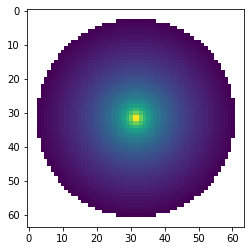

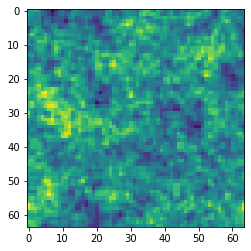

In [4]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
plt.imshow(m)

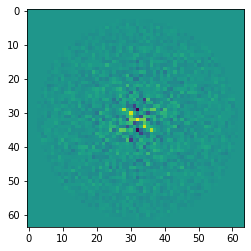

In [5]:
#Generate D

fft2d = np.fft.fft2(m)
plt.imshow(np.fft.fftshift(fft2d).real)

In [12]:
masked_fft_low = ell2d * fft2d
masked_fft_high = (1-ell2d) * fft2d

In [13]:
flat_low = masked_fft_low.flatten()
flat_high = masked_fft_high.flatten()

NameError: name 'masked_fft_low' is not defined

In [ ]:
plt.imshow(flat_low.reshape(nside, nside).real)
plt.colorbar()

In [ ]:
kept_indices_low = np.where(ell2d.flatten() == 1)[0]
kept_indices_high = np.where(ell2d.flatten() == 0)[0]

In [ ]:
shortened_low = flat_low[kept_indices_low]
shortened_high = flat_high[kept_indices_high]

In [14]:
reload(lib)
M_low, M_high = lib.generate_mask(nside, pix_size, ell_cutoff=300)

In [ ]:
f = M_high @ shortened_high
plt.imshow(f.reshape(nside, nside).real)
plt.colorbar()

In [ ]:
m_lf = D_inv @ M_low @ shortened_low
m_hf = D_inv @ M_high @ shortened_high

In [ ]:
recon_map = (m_hf + m_lf).reshape(nside, nside)

In [7]:
plt.imshow(recon_map.real)

NameError: name 'recon_map' is not defined

In [124]:
assert np.max(np.abs(m - recon_map)) < 1e-10

AssertionError: 

NameError: name 'm_lf' is not defined

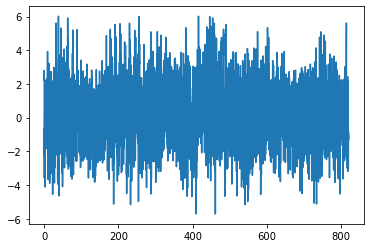

In [8]:
signal = P@m.flatten()
plt.plot(times, signal, label='total')
plt.plot(times, P @ m_lf, label='low_freq')
plt.plot(times, P @ m_hf, label='high_freq')
plt.legend()
plt.grid()

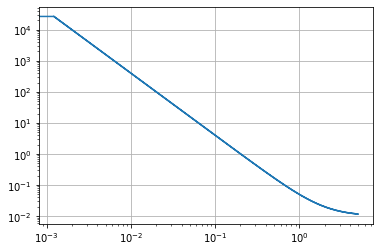

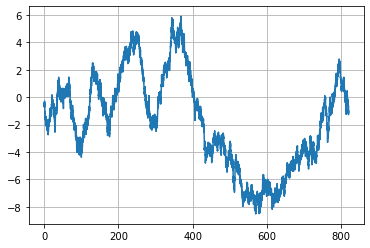

In [9]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=1e-1)
plt.plot(times, noise)
plt.grid()

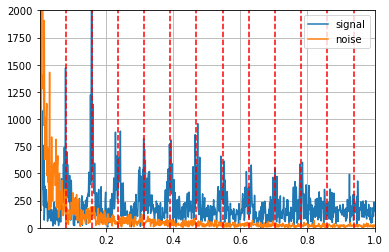

In [127]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')

for i in range(20):
    plt.axvline((i+1)/2/nside*rate, color = 'r', linestyle='dashed')

plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.ylim([0, 2000])
plt.xlim([0.001, 1])
plt.grid()

In [128]:
y = signal + noise # + n

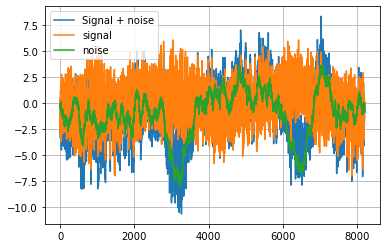

In [129]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [10]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = lib.generate_baselines(baseline_length, nsamp, rate)

In [16]:
from scipy.linalg import dft

dft1 = dft(nside)
D = np.kron(dft1, dft1)
D_inv = np.linalg.inv(D)  

In [17]:
G = P @ D_inv @ M_high
Z = np.eye(nsamp) - G @ np.linalg.inv(G.T @ G) @ G.T

np.abs(Z@Z - Z).max()

19650794619027.527

In [18]:
np.linalg.matrix_rank(G), np.linalg.cond(G)

(3848, 1.0000000000002283)

In [19]:
np.linalg.matrix_rank(G.T @G), np.linalg.cond(G.T @ G)

(3823, 7093254079824991.0)

In [16]:
#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ (y - P @ m_lf)

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

(82, 82) 82


/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


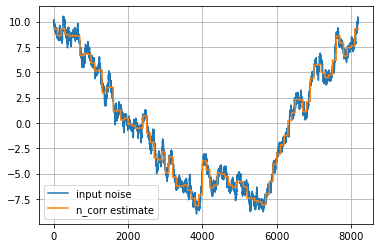

In [17]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [18]:
solver = np.linalg.inv(G.T @ G) @ G.T
m_fourier = solver @ (y  - F @ a - P @ m_lf) 

Input map std: 1.0686935607467283
Solved map std: 66670.06148487791


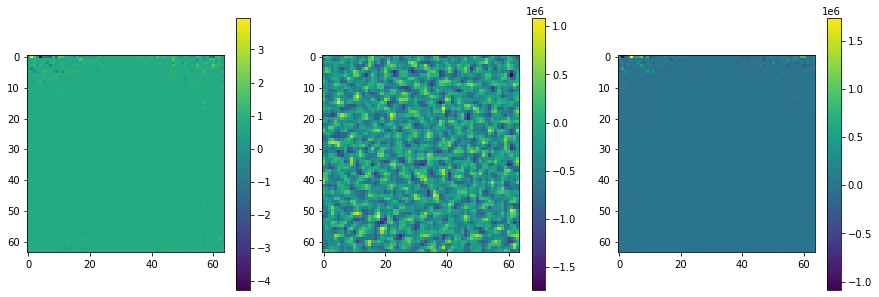

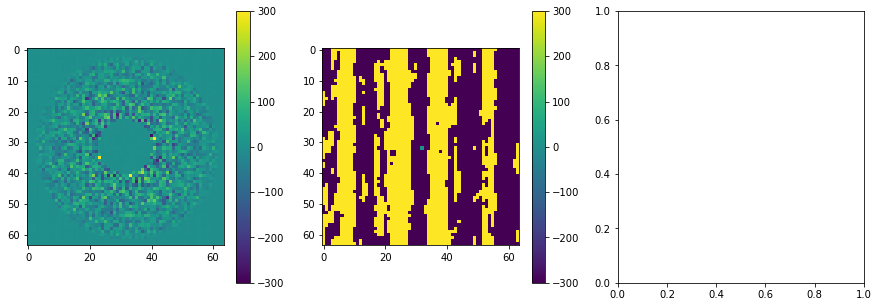

In [19]:
#TESTING IN REAL SPACE
m_fourier -= np.mean(m_fourier)

fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[1].imshow(m_hf.reshape(nside, nside).real)
output_map = axes[0].imshow(m_fourier.reshape(nside, nside).real)
diff_map = axes[2].imshow((m_hf - m_fourier).reshape(nside, nside).real)

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

print(f'Input map std: {np.std(m_hf)}')
print(f'Solved map std: {np.std(m_fourier)}')

fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(np.fft.fftshift((D @ m_hf).reshape(nside, nside)).real, vmin=-300, vmax=300)
output_map = axes[1].imshow(np.fft.fftshift((D @ m_fourier).reshape(nside, nside)).real, vmin=-300, vmax=300)

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])


In [20]:
#Special handling of the fourier solution to set the low freq component to 0
m_fourier_hf = ell2d_c * m_fourier.reshape(nside, nside)

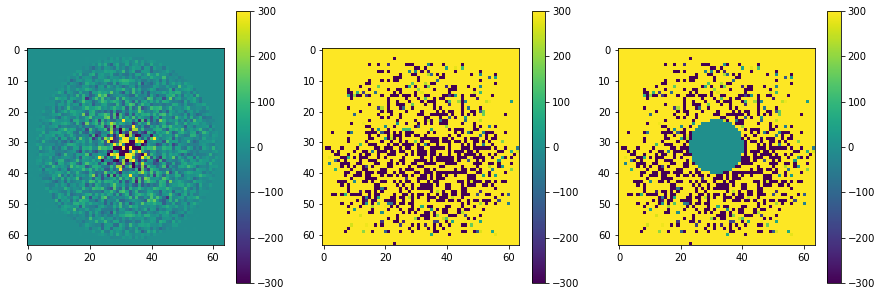

In [21]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))


input_fft = axes[0].imshow(np.fft.fftshift((D @ m.flatten()).reshape(nside, nside)).real, vmin=-300, vmax=300)
output_fft = axes[1].imshow(np.fft.fftshift(m_fourier.reshape(nside, nside)).real, vmin=-300, vmax=300)
masked_fft = axes[2].imshow(np.fft.fftshift(m_fourier_hf.reshape(nside, nside)).real, vmin=-300, vmax=300)

fig.colorbar(input_fft, ax=axes[0])
fig.colorbar(output_fft, ax=axes[1])
fig.colorbar(masked_fft, ax=axes[2])

In [22]:
#Inverse fft to get back the original map
m_destripe = D_inv @ m_fourier_hf.flatten()

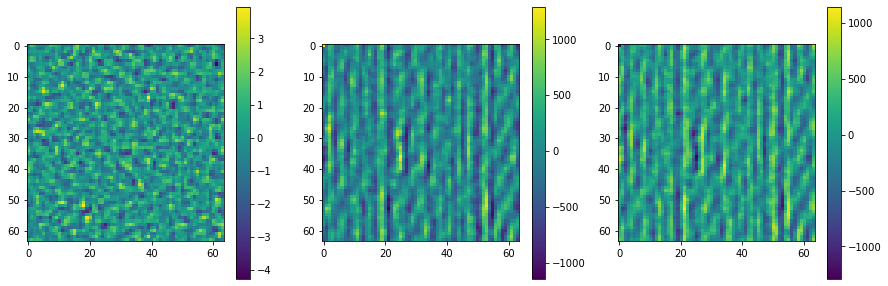

Input map std: 1.0686935607467283
Solved map std: 529.3944081025192


In [23]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m_hf.reshape(nside, nside).real)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside).real)
diff_map = axes[2].imshow((m_hf - m_destripe).reshape(nside, nside).real)

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m_hf)}')
print(f'Solved map std: {np.std(m_destripe)}')